In [1]:
import numpy as np
import scipy.stats as sts
from matplotlib import pyplot as plt
from scipy.special import gammainc

In [2]:
data_path="../../../DATA/LHCO/"
mjj_bg = np.load(data_path+"mjj_bkg_sort.npy")
mjj_sg = np.load(data_path+"mjj_sig_sort.npy")
n_bins =16
region=[3000, 4600]
bins=np.linspace(region[0], region[1], n_bins+1)
bin_centers = (bins[1:] + bins[:-1]) / 2
x=bin_centers


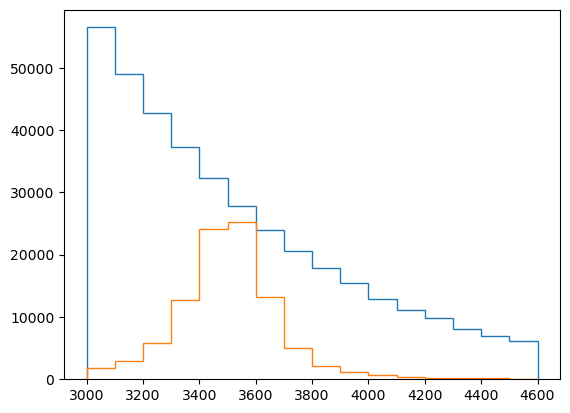

In [3]:
hist_bg = plt.hist(mjj_bg, bins=bins, histtype='step')
hist_sg = plt.hist(mjj_sg, bins=bins, histtype='step')
hist_bg=hist_bg[0]
hist_sg=hist_sg[0]

In [4]:
sg_frac = 0.025
true_frac = np.sum(sg_frac*hist_sg)/np.sum(sg_frac*hist_sg + hist_bg)
true_frac

0.0062852028161596235

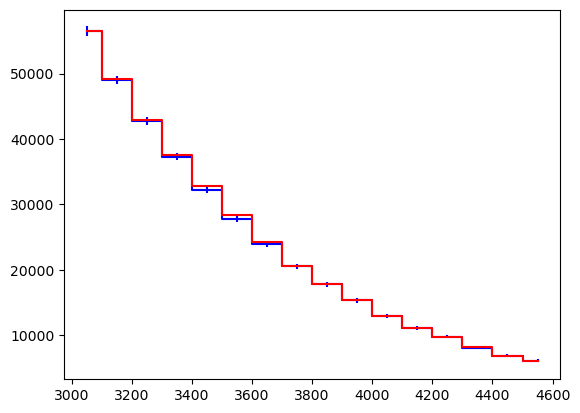

In [5]:

sigma_bg=np.sqrt(hist_bg)
plt.step(x, hist_bg, where='mid', color="blue")
plt.errorbar(x, hist_bg, yerr=np.sqrt(hist_bg)*3 ,linestyle="", color="blue")
plt.step(x, hist_bg+hist_sg*sg_frac, where='mid', color="red")

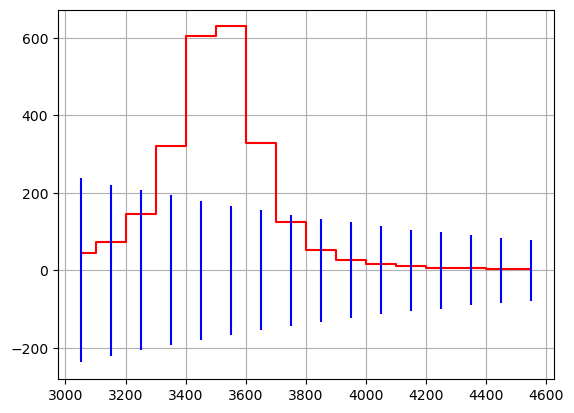

In [6]:
plt.step(x, hist_sg*sg_frac, where='mid', color="red")
plt.errorbar(x, x*0, yerr=sigma_bg ,linestyle="", color="blue")
plt.grid()

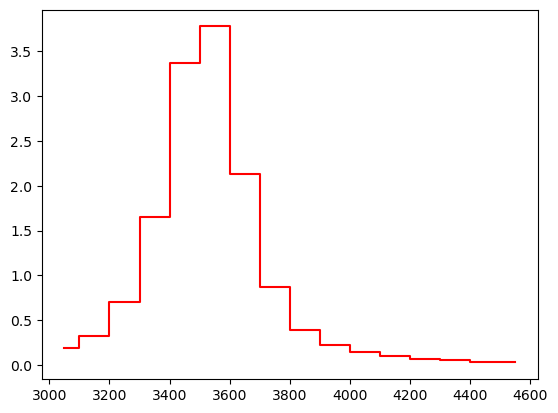

In [7]:
plt.step(x, hist_sg*sg_frac/sigma_bg, where='mid', color="red")

In [8]:
max_dev_sig=np.max(hist_sg*sg_frac/sigma_bg)
max_dev_sig

3.774913117504191

In [9]:
p_value = sts.norm.sf(max_dev_sig)
p_value

8.003172054130478e-05

In [10]:
p_global=1-(1-p_value)**16
p_global

0.0012797392064918256

In [11]:
s_global=-sts.norm.ppf(p_global)

In [12]:
n_bootstraps = 1000

bootstrap_bg = np.random.choice(mjj_bg, size=(n_bootstraps, len(mjj_bg)))
len(bootstrap_bg[0])

1000000

In [13]:
max_devs=[]
for i in range(n_bootstraps):
	hist_bg_boot = np.histogram(bootstrap_bg[i], bins=bins)
	hist_bg_boot = hist_bg_boot[0]
	max_dev=np.max((hist_bg_boot-hist_bg)/sigma_bg)
	max_devs.append(max_dev)
max_devs=np.array(max_devs)

0.001


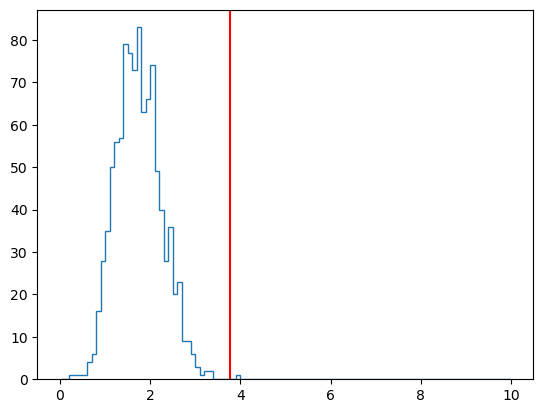

In [14]:
plt.hist(max_devs, bins=100, range=(0, 10), histtype='step')
plt.axvline(max_dev_sig, color="red")
print(np.sum(max_devs>max_dev_sig)/n_bootstraps)

In [15]:
def get_hunter_scheme(hunter) -> np.ndarray:
    if hunter.str_scale == "lin":
        sig_str = np.arange(
            hunter.str_min,
            hunter.str_min + hunter.str_step * len(hunter.sigma_ar),
            step=hunter.str_step,
        )
    else:
        sig_str = np.array(
            [
                i % 10 * 10 ** (hunter.str_min + i // 10)
                for i in range(len(hunter.sigma_ar) + len(hunter.sigma_ar) // 10 + 1)
                if i % 10 != 0
            ]
        )
    return sig_str


In [16]:
 # Create a BumpHunter1D class instance
import pyBumpHunter as BH
hunter = BH.BumpHunter1D(
    rang=[3000, 4600],
    width_min=2,
    width_max=10,
    width_step=2,
    scan_step=1,
    npe=100000,
    nworker=6,
    seed=42,
    use_sideband=True,
    str_min=-5,
    sigma_limit=8,
    str_scale="log",
)

# Run the bump hunter without any cuts
hunter.signal_inject(mjj_bg, mjj_sg)
raw_str = get_hunter_scheme(hunter)
raw_sens = hunter.sigma_ar.copy()
min_l = min(len(raw_sens), len(raw_str))  # Sometimes the hunter lengths dont match
raw_sens = raw_sens[:min_l]
raw_str = raw_str[:min_l]




Generating background only histograms
5 values of width will be tested
BACKGROUND ONLY SCAN
STARTING INJECTION
   STEP 1 : signal strength = 1e-05
Generating background+signal histograms
BACKGROUND+SIGNAL SCAN
Global p-value : 0.4825  (48246 / 100000)   0.7961  (79609)   0.1537  (15365)
Significance = 0.04398 (-0.82774  1.02090)

   STEP 2 : signal strength = 2e-05
Generating background+signal histograms
BACKGROUND+SIGNAL SCAN
Global p-value : 0.4831  (48307 / 100000)   0.8773  (87726)   0.1840  (18398)
Significance = 0.04245 (-1.16140  0.90030)

   STEP 3 : signal strength = 3.0000000000000004e-05
Generating background+signal histograms
BACKGROUND+SIGNAL SCAN
Global p-value : 0.5266  (52660 / 100000)   0.8496  (84963)   0.1462  (14617)
Significance = -0.06673 (-1.03485  1.05300)

   STEP 4 : signal strength = 4e-05
Generating background+signal histograms
BACKGROUND+SIGNAL SCAN
Global p-value : 0.5286  (52865 / 100000)   0.8679  (86785)   0.1015  (10153)
Significance = -0.07188 (-1.116

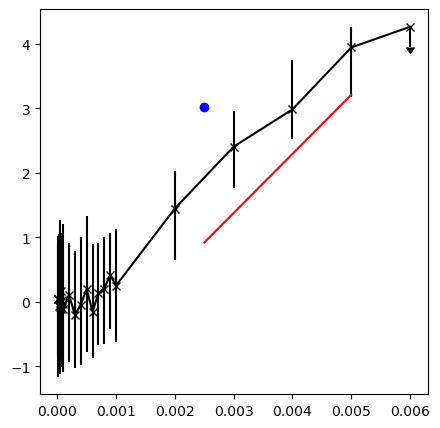

In [18]:
# Create the figure
fig = plt.figure(figsize=(5, 5))
plt.errorbar(
    raw_str,
    raw_sens[:, 0],
    xerr=0,
    yerr=[raw_sens[:, 1], raw_sens[:, 2]],
    marker="x",
    color="k",
    uplims=raw_sens[:, 2] == 0,
    label="raw data",
)
plt.plot([0.005, 0.0025], [3.21, 0.92], color="red")
plt.scatter([sg_frac*0.1], [s_global], color="blue")